In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
from scipy.fft import fft, fftfreq

from modules.utils import FeedForwardNetwork, l2, create_animation, clear_temp, plot_frequencies
from modules.problems import oscillator

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [3]:
clear_temp()

In [21]:
from modules.efficient_kan import KAN

def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

L, W = 2, 32
# model = FeedForwardNetwork(L, W, activation=nn.Tanh())
model = KAN([1, 10, 1], grid_size=25)
name = 'testing_kan'

problem = oscillator.DampedHarmonicOscillator.get_problem(1)

coef = 0.75
lr = 1e-2
N_F = 1024

num_iters = 150
plot_every = 1

result = problem.train(
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {'lr': lr},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR,
            'parameters': {'step_size': 20000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {'N_F': N_F},
            'generation_function': f
        },
        'coefs': [[coef], [1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    plotting_params={
        'plot_every': plot_every,
        'save_dir': f'./.temp/',
        'size': (5, 3),
        'plot_solution': True,
        'plot_freq': False
    },
    logging_params={
        'loss': 1,
        'norms': -1,
        'steps': -1,
        'error': 1,
        'log_dir': None
    },
    name=name,
    show_progress=True
)

Logs will be written to ./logging/testing_kan.json.


  0%|          | 0/150 [00:00<?, ?it/s]

Iter   149 	 Loss: 0.04885 --- Error: 0.18728: 100%|██████████| 150/150 [02:15<00:00,  1.11it/s] 


In [22]:
create_animation(
    [f'.temp/{name}_iteration_{i}.png' for i in range(0, num_iters, plot_every)],
    f'../images/animations/dho/{name}.mp4',
    fps=30, type='mp4'
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1058, 706) to (1072, 720) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


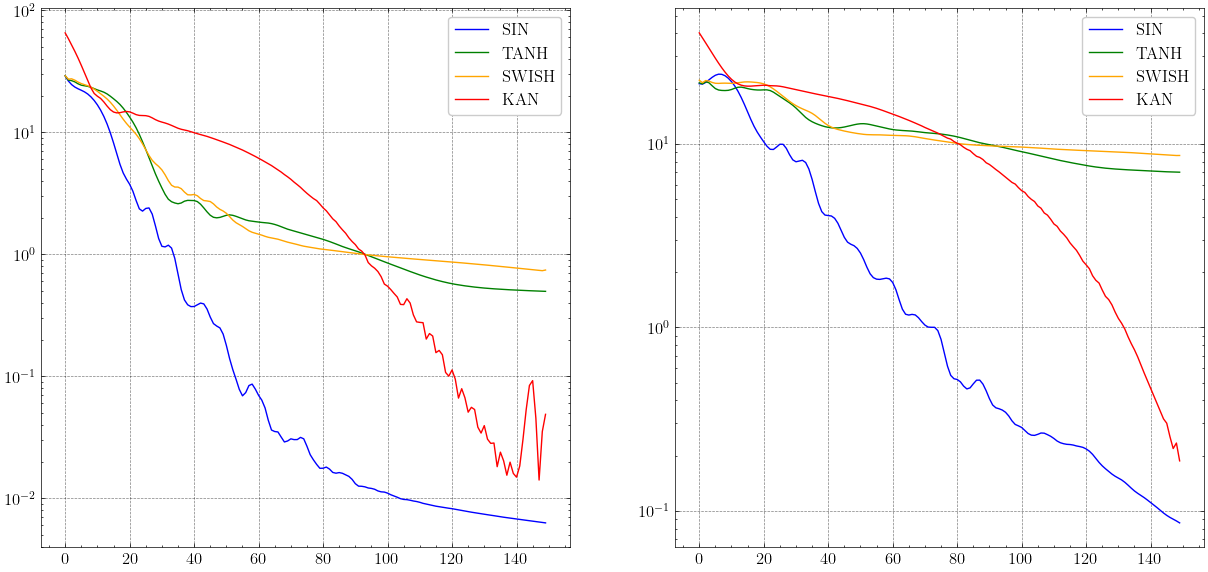

In [23]:
import json
files = ['./logging/testing_sin.json', './logging/testing_tanh.json', './logging/testing_swish.json', './logging/testing_kan.json']
colors = ['blue', 'green', 'orange', 'red']
names = ['SIN', 'TANH', 'SWISH', 'KAN']

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

iters = np.arange(0, num_iters)
for i, name in enumerate(names):
    with open(files[i], 'r') as file:
        log = json.load(file)

    loss_history = []
    error_history = []
    # step_history = []
    # weight_norms = []
    # gradient_norms = []
    for j in range(0, num_iters):
        loss_history.append( log[str(j)]['loss'])
        error_history.append(log[str(j)]['error'])
        # step_history.append( log[str(j)]['step'])
        
        # norms = log[str(j)]['norms']
        
        # w_norms = []
        # g_norms = []
        # for layer, values in norms.items():
        #     w_norms.append(values[0])
        #     g_norms.append(values[1])
            
        # weight_norms.append(np.mean(w_norms))
        # gradient_norms.append(np.mean(g_norms))
        
    loss_history =  np.array(loss_history )
    error_history = np.array(error_history)
    # step_history =  np.array(step_history )
    
    # ax[0][0].plot(iters, loss_history[:, 2], label=name, color=colors[i])
    
    # ax[1][0].plot(iters, error_history, label=name, color=colors[i])
    # ax[1][0].plot(iters, step_history, label=activ, linestyle='dashed', color=colors[i])
    
    ax[0].plot(iters, loss_history[:, 2], label=name, color=colors[i])
    ax[1].plot(iters, error_history, label=name, color=colors[i])
    # 
    # ax[0].plot(iters, step_history, label='Step', linestyle='dashed', color=colors[i])
    # ax[1].plot(iters, weight_norms, label='Weights', color=colors[i])
    # ax[1].plot(iters, gradient_norms, label='Grads', color=colors[i])

ax[0].legend()
ax[1].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')

# ax[0].vlines([350], ymin=min(loss_history[:, 2]), ymax=max(loss_history[:, 2]), colors=['black'], linestyle=':')
# ax[1].vlines([350], ymin=min(gradient_norms), ymax=max(gradient_norms), colors=['black'], linestyle=':')

plt.show()

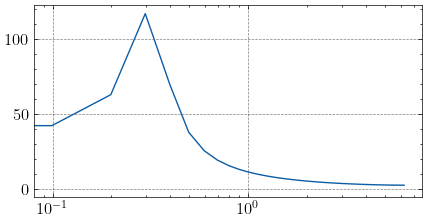

In [9]:
import numpy as np
from scipy.fft import fft, fftfreq

def solution(t):
    A = 4.59279
    B = 5
    C = 1.95959
    return np.exp(-0.4*t) * (A*np.sin(C*t) + B*np.cos(C*t))

N = 128
t = np.linspace(0, 10, N)
sol = solution(t)
fsol = fft(sol - sol.mean())
freqs = fftfreq(len(fsol), t[1] - t[0])

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.plot(freqs[:N//2], np.abs(fsol)[:N//2])
ax.set_xscale('log')
plt.show()

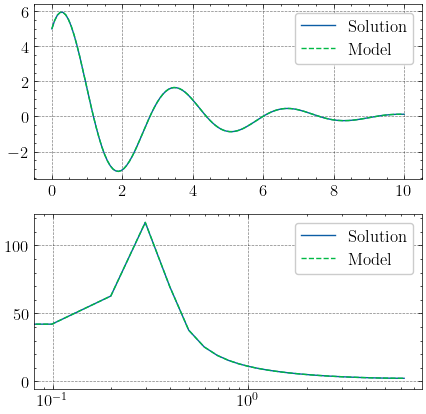

In [3]:
dho1 = oscillator.DampedHarmonicOscillator.get_problem(1)
dho1.plot_frequencies(solution(dho1.domain).numpy())
plt.show()

In [2]:
import torch 
from torch.autograd import grad
from torch.autograd.functional import jacobian

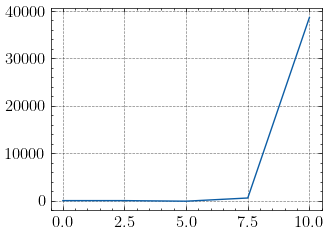

In [47]:
x = torch.linspace(0, 10, 5, requires_grad=True)
y = torch.exp(x) * (torch.sin(2*x) - torch.cos(x))
plt.plot(x.detach(), y.detach())

In [77]:
%%timeit
x1 = torch.linspace(0, 10, 5, requires_grad=True)
x2 = torch.linspace(0, 10, 5, requires_grad=True)
x3 = torch.linspace(0, 10, 5, requires_grad=True)
x4 = torch.linspace(0, 10, 5, requires_grad=True)
y = torch.exp(x1 + x2) * (torch.sin(x3) - torch.cos(x4))
dx1 = grad(y, x1, torch.ones_like(y), create_graph=True)[0]
dx2 = grad(y, x2, torch.ones_like(y), create_graph=True)[0]
dx3 = grad(y, x3, torch.ones_like(y), create_graph=True)[0]
dx4 = grad(y, x4, torch.ones_like(y), create_graph=True)[0]

637 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [78]:
%%timeit
def f(a, b, c, d):
    return torch.exp(a + b) * (torch.sin(c) - torch.cos(d))
x1 = torch.linspace(0, 10, 5, requires_grad=True)
x2 = torch.linspace(0, 10, 5, requires_grad=True)
x3 = torch.linspace(0, 10, 5, requires_grad=True)
x4 = torch.linspace(0, 10, 5, requires_grad=True)
J = jacobian(f, (x1, x2, x3, x4), vectorize=True)
da = torch.diagonal(J[0])
db = torch.diagonal(J[1])
dc = torch.diagonal(J[2])
dd = torch.diagonal(J[3])

800 µs ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1]:
import numpy as np
import torch
import random

np.random.seed(42)
torch.random.manual_seed(42)
random.seed(42)

In [5]:
import os
os.environ['GLOBAL_SEED'] = str(42)
os.environ['GLOBAL_SEED']

'42'

In [9]:
import optuna

activation_functions = [nn.Tanh(), SinActivation(), Swish()]
activation_names = ['tanh', 'sin', 'swish']

for problem_number in [1, 2, 3, 4]:
    problem = oscillator.DampedHarmonicOscillator.get_problem(problem_number)
    for activ_name, activ_func in zip(activation_names, activation_functions):
        name = f'dho{problem_number}_{activ_name}'
        activation = activ_func

        study = optuna.create_study(study_name=name, direction='minimize', sampler=optuna.samplers.GPSampler(n_startup_trials=5))
        study.optimize(objective, n_trials=15)
        
        study.trials_dataframe().to_csv(f'./studies/{study.study_name}.csv', sep=',')

C:\Temp\ipykernel_10956\3347617693.py:12: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(study_name=name, direction='minimize', sampler=optuna.samplers.GPSampler(n_startup_trials=5))
[I 2024-04-16 19:41:55,751] A new study created in memory with name: dho1_tanh
Iter   788 	 4.168194420617455:  11%|█         | 789/7500 [00:30<01:28, 76.08it/s][I 2024-04-16 19:43:04,249] Trial 0 finished with value: 0.94241804784501 and parameters: {'coef': 0.24344066534380682, 'lr': 0.018930556719432376, 'NF': 1536}. Best is trial 0 with value: 0.94241804784501.
[I 2024-04-16 19:44:12,897] Trial 1 finished with value: 1.2824252079383822 and parameters: {'coef': 0.2628563597406133, 'lr': 0.002137369213200958, 'NF': 1536}. Best is trial 0 with value: 0.94241804784501.
[I 2024-04-16 19:45:18,279] Trial 2 finished with value: 1.6777969872543526 and parameters: {'coef': 0.328550151672515, 'lr': 0.001730830429141859

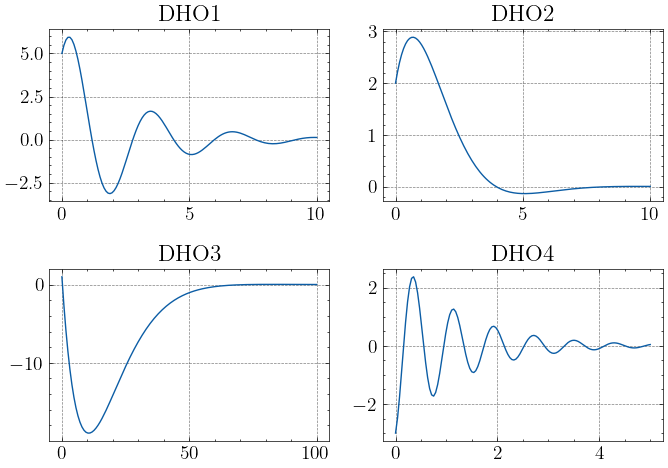

In [9]:
mpl.rcParams["font.size"] = "14"
problems = [oscillator.DampedHarmonicOscillator.get_problem(i) for i in range(1, 5)]

size = (7, 5)
fig, axs = plt.subplots(2, 2, figsize=size)
for (i, j), (ind, problem) in zip([(0, 0), (0, 1), (1, 0), (1, 1)], enumerate(problems)):
    axs[i, j].plot(problem.domain, problem.solution)
    axs[i, j].title.set_text(f'DHO{ind+1}')
    
plt.tight_layout()

plt.savefig('../images/dho_grid_2.png', dpi=250)
plt.show()

## Hyperparameter analysis
---

In [3]:
import pandas as pd
from datetime import datetime

def convert(duration):
    time = datetime.strptime(duration[7:], '%H:%M:%S.%f')
    return time.second + time.minute*60 + time.hour*3600

def get_df(name, to_drop, names):
    
    tanh = pd.read_csv(f'./studies/{name}_tanh.csv').drop(to_drop, axis=1)
    tanh['activation'] = 'tanh'
    
    sin = pd.read_csv(f'./studies/{name}_sin.csv').drop(to_drop, axis=1)
    sin['activation'] = 'sin'
    
    swish = pd.read_csv(f'./studies/{name}_swish.csv').drop(to_drop, axis=1)
    swish['activation'] = 'swish'
    
    for df in [tanh, sin, swish]:
        df.columns = names
        df['Duration'] = df['Duration'].apply(convert)
        
    return pd.concat([tanh, sin, swish])

to_drop = ['Unnamed: 0', 'datetime_start', 'datetime_complete', 'state']

In [41]:
dho1 = get_df('dho1', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
dho2 = get_df('dho2', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
dho3 = get_df('dho3', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])
dho4 = get_df('dho4', to_drop, ['Trial', 'L2', 'Duration', 'NF', 'C', 'lr', 'Activation'])

In [46]:
dho1.at[0, 'Activation']

0    0
0    0
0    0
Name: Activation, dtype: object

In [43]:
dho1

,Trial,L2,Duration,NF,C,lr,Activation
0,0,0.942418,68,1536,0.243441,0.018931,0
1,1,1.282425,68,1536,0.262856,0.002137,tanh
2,2,1.677797,65,1024,0.328550,0.001731,tanh
3,3,0.122596,76,2048,0.270472,0.024559,tanh
4,4,0.419372,66,1536,0.261132,0.001605,tanh
5,5,3.269447,77,2048,0.050000,0.001000,tanh
6,6,0.206851,68,1536,0.498272,0.001000,tanh
7,7,21.155154,76,2048,0.311009,0.071693,tanh
8,8,0.247233,74,2048,0.950000,0.012045,tanh
9,9,1.934054,76,2048,0.950000,0.001544,tanh


In [90]:
dho1.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
13,13,0.014111,86,2048,0.950000,0.001,sin
12,12,0.014357,65,1024,0.950000,0.001,sin
5,5,0.014391,66,1024,0.079281,0.001,sin
10,10,0.014495,63,1024,0.153628,0.001,sin
11,11,0.015671,79,2048,0.050000,0.001,sin


In [78]:
dho1.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,4.896262,72.266667,1501.866667,0.364451,0.032609
swish,7.0,1.526899,112.400000,1672.533333,0.487030,0.025362
tanh,7.0,2.593703,71.733333,1774.933333,0.497931,0.012952


In [79]:
dho1.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,8.752625,8.472364,528.791326,0.345027,0.040930
swish,4.472136,2.702954,10.224620,492.108854,0.356051,0.034047
tanh,4.472136,5.240869,5.712976,380.530357,0.350263,0.018259


In [91]:
dho2.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
13,13,0.003907,67,2048,0.95,0.001596,sin
7,7,0.004280,94,1024,0.05,0.002968,swish
14,14,0.004320,56,1024,0.05,0.001598,sin
5,5,0.004444,111,2048,0.05,0.003277,swish
8,8,0.004473,56,1024,0.95,0.002456,sin


In [60]:
dho2.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,0.811850,63.066667,1604.266667,0.554370,0.016342
swish,7.0,2.801065,104.466667,1604.266667,0.379778,0.037404
tanh,7.0,1.257938,65.533333,1467.733333,0.435328,0.016600


In [85]:
dho2.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,3.029321,6.273148,507.100366,0.395322,0.024682
swish,4.472136,5.881163,10.881614,468.723413,0.275012,0.044117
tanh,4.472136,3.524380,5.054936,468.723413,0.351977,0.025721


In [92]:
dho3.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
13,13,0.017906,71,2048,0.050000,0.011549,sin
9,9,0.069346,58,1024,0.050000,0.001000,sin
0,0,0.080522,103,1536,0.521464,0.003653,swish
6,6,0.081580,119,2048,0.359800,0.003720,swish
14,14,0.107332,62,1024,0.050000,0.020717,tanh


In [59]:
dho3.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,10.106913,68.133333,1638.400000,0.373106,0.011820
swish,7.0,1.586562,111.733333,1570.133333,0.445932,0.006286
tanh,7.0,22.679413,68.400000,1604.266667,0.261091,0.016915


In [86]:
dho3.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,23.531104,7.259149,519.262774,0.265537,0.024731
swish,4.472136,2.197305,10.381761,452.462132,0.340525,0.010546
tanh,4.472136,36.445501,6.389724,507.100366,0.316750,0.023880


In [93]:
dho4.sort_values(['L2']).head(5)

,Trial,L2,Duration,NF,C,lr,Activation
9,9,0.012131,58,1024,0.950000,0.038732,sin
13,13,0.014068,64,1024,0.709422,0.036804,sin
14,14,0.016575,64,1536,0.950000,0.001652,sin
10,10,0.045946,60,1024,0.950000,0.001000,sin
11,11,0.050503,71,2048,0.950000,0.001000,sin


In [58]:
dho4.groupby(['Activation']).mean()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,7.0,3.016229,61.733333,1297.066667,0.579837,0.035372
swish,7.0,3.361214,108.866667,1706.666667,0.765841,0.018469
tanh,7.0,4.504501,68.000000,1638.400000,0.698271,0.018792


In [87]:
dho4.groupby(['Activation']).std()

,Trial,L2,Duration,NF,C,lr
Activation,,,,,,
sin,4.472136,3.713564,4.431489,380.530357,0.326018,0.033243
swish,4.472136,2.021593,8.484159,460.664530,0.282440,0.028784
tanh,4.472136,3.532885,5.490251,441.288503,0.344250,0.031721
